[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/109_cfd_galerkin/109_cfd_galerkin.ipynb)

En los posts anteriores hemos visto como podemos resolver ecuaciones diferenciales mediante el método de volúmenes finitos. Estos métodos son potentes y sus propiedades son ideales para resolver el tipo de problemas que nos interesan, sin embargo son métodos de bajo órden lo cual implica errores de aproximación que afectan a nuestra solución (upwind es difusivo, central acumula errores).  Ésto puede aliviarse usando métodos de alto órden, pero su implementación en volúmenes finitos se incrementa (sobretodo en mallas no estructuradas) no siendo del todo útil. Para ello podemos recurrir a otra familia de métodos numéricos que combinan lo bueno de los volúmenes finitos con la posibilidad de representar la solución en cada celda mediante polinomios de alto order: los métodos de Galerkin.

https://www.youtube.com/watch?v=tK1HbAiCPuw&list=PLc4eVvgECLtptmgobxxXmVikejqPf4f8D

## Método de Galerkin Discontinuo

$$
\phi_t + f_x(\phi) = 0
$$

Vamos a resolver la PDE en su forma débil

$$
\int_{\Omega} \phi_t q dx + \int_{\Omega} f_x(\phi) q dx = 0
$$

donde $q$ es una función de prueba (por qué esto funciona?). Para cada celda

$$
\int_{x_1}^{x_2} \phi_t q dx + f(\phi_2)q_2 - f(\phi_1)q_1 - \int_{x_1}^{x_2} f(\phi) q_x dx = 0
$$

Tenemos lo mismo que para FVM pero al haber añadido la función de prueba aparece un término extra al integrar el flujo por partes.

En FVM asumimos valor constante en cada celda, ahora representaremos $\phi_i$ como un polinomio.

$$
\tilde{\phi}(x) = \sum_{i=0}^M a_i \psi_i(x)
$$

donde $a_i$ son coeficientes y $\psi(x)$ son las funciones o vectores bases del polinomio. Si $M=0$ tendremos la misma solución que con FVM. A medida que aumentemos $M$ nos acercaremos más a la solución exacta (en toería). Vamos a ver un primer ejemplo con $M=1$ usando dos funciones bases lineales.

$$
\tilde{\phi}(x) = a_0(1-x) + a_1x
$$

In [9]:
import numpy as np 

x = np.linspace(0,1,2)
x

array([0., 1.])

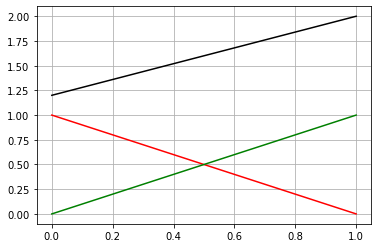

In [10]:
import matplotlib.pyplot as plt

p1 = 1 - x 
p2 = x 

a0, a1 = 1.2, 2
p = a0*p1 + a1*p2

plt.plot(x, p1, "r-")
plt.plot(x, p2, "g-")
plt.plot(x, p, "k-")
plt.grid(True)
plt.show()

Escogiendo $q_j = \psi_j$ tenemos

$$
\int_{x_1}^{x_2} \tilde{\phi}_t q_j dx = \sum_{i=0}^M \frac{da_i(t)}{dt} \int_{x_1}^{x_2} \psi_i(x) q_j(x) dx = M a
$$

donde $M$ se conoce como la matriz de masa. Para el ejemplo q1e estamos haciendo

$$
M = 
\begin{bmatrix}
\int_{x_1}^{x_2} (1-x) (1-x) dx & \int_{x_1}^{x_2} (1-x) x dx \\
\int_{x_1}^{x_2} x (1-x) dx & \int_{x_1}^{x_2} x x dx
\end{bmatrix} = 
\begin{bmatrix}
\frac{1}{3} (x_2-x_1) & \frac{1}{6} (x_2-x_1) \\
\frac{1}{6} (x_2-x_1) & \frac{1}{3} (x_2-x_1)
\end{bmatrix}
= 
\begin{bmatrix}
\frac{1}{3} & \frac{1}{6} \\
\frac{1}{6} & \frac{1}{3}
\end{bmatrix}
$$

(generado con copilot (L))

Asumiendo que nuestro flujo es $f = u \phi$ donde $u$ es contante, tenemos

$$
\int_{x_1}^{x_2} f(\phi) q_x dx = \sum_{i=0}^M u a_i(t) \int_{x_1}^{x_2} \phi_i q'_j dx = u K a
$$

donde $K$ se conoce como la matriz de rigidez. Para el ejemplo que estamos haciendo

$$
K =
\begin{bmatrix}
\int_{x_1}^{x_2} (1-x) 1 dx & \int_{x_1}^{x_2} x (-1) dx \\
\int_{x_1}^{x_2} (1-x) 1 dx & \int_{x_1}^{x_2} x (1) dx
\end{bmatrix} =
\begin{bmatrix}
- \frac{1}{2} & -\frac{1}{2}  \\
\frac{1}{2}  & \frac{1}{2} 
\end{bmatrix}
$$

El último término lo calcularemos usando nuestro esquema numérico favorito, en el caso del upwind asumiendo $u > 0$ tenemos

$$
f(\phi_2)q_2 - f(\phi_1)q_1 = u q_k (x_2) \phi_j (x_2) - u q_{k-1} (x_2) \phi_j (x_1) = f
$$

donde

$$
f = u \begin{bmatrix}
- q_{k-1} (x_2)  \\
q_k (x_2) 
\end{bmatrix}
$$

Poniéndolo todo junto

$$
\int_{x_1}^{x_2} \frac{da_i(t)}{dt} =  [u K a - f] M^{-1}
$$

que podemos integrar para obtener $a(t)$ usando nuestro método favorito (Euler, AB2, RK, ...)

Ahora nuestras celdas están definidas por dos puntos, en este caso coincide con las caras.

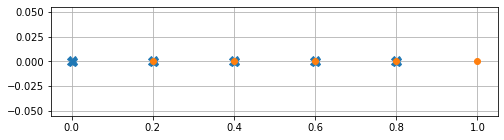

In [30]:
import numpy as np 
import matplotlib.pyplot as plt

def geom(N, x0=0, x1=1):
    f = np.linspace(x0, x1, N+1)
    # c = np.array([0.5*(f[i] + f[i+1]) for i in range(N)])
    c = [[f[i], f[i+1]] for i in range(N)]
    x = [[0, 1] for i in range(N)]
    return c, x

c, _ = geom(5)

plt.figure(figsize=(8, 2))
plt.plot([_c[0] for _c in c], [0 for _ in c], 'X', markersize=10)
plt.plot([_c[1] for _c in c], [0 for _ in c], 'o')
plt.grid(True)
plt.show()

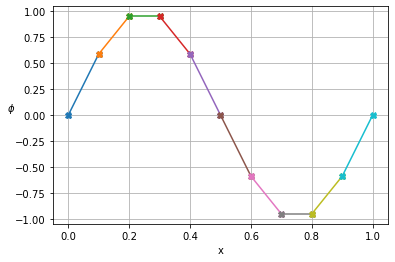

In [34]:
c, x = geom(10)

def smooth(c):
    a0 = []
    for c1, c2 in c:
        a0.append([np.sin(2 * np.pi * c1), np.sin(2 * np.pi * c2)])
    return np.array(a0)

a0 = smooth(c)

for (a1,a2), (c1,c2), (x1,x2) in zip(a0, c, x):
    plt.plot([c1, c2], [a1*(1-x1)+a2*x1, a1*(1-x2)+a2*x2], 'X-')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.show()

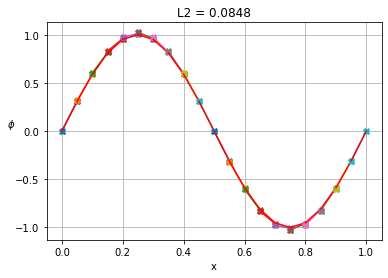

In [238]:
# parmámetros
c, x = geom(20)
u, dt, t, tf = 1, 0.001, 0, 1

# condiciones iniciales
a0 = smooth(c)
R0 = np.zeros_like(a0)

# matrices 
K = np.array([[-0.5, -0.5], [0.5, 0.5]])
M = np.array([[1./3, 1./6], [1./6, 1./3]])
Minv = np.linalg.inv(M)

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	R = np.zeros_like(a0)
	f = np.zeros_like(a0)
	a = np.zeros_like(a0)
	for i in range(len(c)):
		# upwind
		if u > 0:
			if i == 0:
				q1 = a0[len(c)-1, 1]
			else:
				q1 = a0[i-1, 1]
			q2 = a0[i,1]
		else:
			q1 = a0[i,0]
			if i == len(c)-1:
				q2 = a0[0,0]
			else:
				q2 = a0[i+1,0]
		# central
		# qlr = a0[i-1, 1] if i > 0 else a0[len(c)-1, 1]
		# qrl = a0[i+1, 0] if i < len(c)-1 else a0[0, 0]
		# ql, qr = a0[i, 0], a0[i, 1]
		# q1 = 0.5*(qlr+ql)
		# q2 = 0.5*(qr+qrl)
		f[i] = u * np.array([-q1, q2])
		R[i] = np.dot(u * np.dot(K, a0[i]) - f[i], Minv) / (c[i][1] - c[i][0])
		# euler
		a[i] = a0[i] + dt*R[i]
		# abs
		# a[i] = a0[i] + 1.5*dt*R[i] - 0.5*dt*R0[i]
	a0 = a.copy()
	R0 = R.copy()

a = a0.copy()
for (a1,a2), (c1,c2), (x1,x2) in zip(a, c, x):
    plt.plot([c1, c2], [a1*(1-x1)+a2*x1, a1*(1-x2)+a2*x2], 'X-')
    plt.plot([c1, c2], [np.sin(2.*np.pi*(c1-u*t)), np.sin(2.*np.pi*(c2-u*t))], 'r-')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.title(f'L2 = {np.linalg.norm(a-np.sin(2*np.pi*(np.array(c)-u*t))):.4f}')
plt.grid(True)
plt.show()

Observo que el dt tiene que ser mucho más pequeño para que haya convergencia.
Luego, upwind y euler funcionan muy bien (no difusión numérica)

Este ejemplo ha servido para ilustrar el método, pero podemos ir más allá (nuestra solución es lineal, queremos poder ir a un orden arbitrario). Para ello tenemos que usar otras funciones base: bases de Lagrange

$$
L_q(x) = \prod_{p=1,p\neq q}^{N_p} \frac{x-x_p}{x_q-x_p}
$$

Tienen propiedades muy interesantes: vale 0 en todos los puntos de interpolación excepto en el nodo base.

$$
\tilde{\phi}(x) = \sum_{i=0}^M a_i \psi_i(x) = \sum_{i=0}^M \phi(x_i) L_i(x)
$$

Los puntos de interpolación que escogeremos serán las raizes de los polinomios de Legendre (permiten integración numérica exacta).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Legendrepolynomials6.svg/640px-Legendrepolynomials6.svg.png)

In [283]:
from scipy.special import roots_legendre, eval_legendre

roots, weights = roots_legendre(1)

roots, weights

(array([0.]), array([2.]))

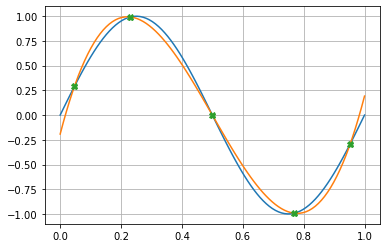

In [334]:
x = np.linspace(0,1,100)
p0 = lambda x: np.sin(2*np.pi*x)
plt.plot(x, [p0(_x) for _x in x])

N = 5
roots, weights = roots_legendre(N)
L = lambda i, x: np.prod([(x-roots[j])/(roots[i]-roots[j]) for j in range(N) if j != i]) 
p = [np.sum([p0(0.5*(roots[i] + 1))*L(i, _x) for i in range(N)]) for _x in x*2-1]

plt.plot(x, p)
plt.plot((roots + 1)/2, [p0(r) for r in (roots + 1)/2], 'X')
plt.grid(True)
plt.show()

Podriamos resolver el problema con una sola celda usando un polinomio de alto orden

Integración numérica exacta

In [332]:
x = np.linspace(0,1,100)
p0 = lambda x: np.sin(2*np.pi*x)
# p0 = lambda x: 1. 
# p0 = lambda x: x

N = 5
roots, weights = roots_legendre(N)
L = lambda i, x: np.prod([(x-roots[j])/(roots[i]-roots[j]) for j in range(N) if j != i]) 
p = [np.sum([p0(0.5*(roots[i] + 1))*L(i, _x) for i in range(N)]) for _x in x*2-1]

np.sum([p0(0.5*(roots[i] + 1))*weights[i] for i in range(N)]) / 2

-1.3877787807814457e-17

Discretización

$$
\int_{x_1}^{x_2} \tilde{\phi}_t q_j dx = \sum_{i=0}^M \frac{d\phi_i(t)}{dt} \int_{-1}^{1} L_i(x) L_j(x) \frac{\Delta x}{2} dx =  \frac{\Delta x}{2} \phi_j' w_j
$$

La matriz de masa es diagonal (se puede invertir fácilmente).

Asumiendo que nuestro flujo es $f = u \phi$ donde $u$ es contante, tenemos

$$
\int_{x_1}^{x_2} f(\phi) q_x dx = \sum_{i=0}^M u \phi_i(t) \int_{-1}^{1} L_i(x) L'_j(x) dx  = \sum_{i=0}^M u \phi_i(t)  w_i L'_j(x_i) = u K \phi
$$

$$
L'_j(x) = L_j \sum_{r=0,r\neq j}^M \frac{1}{x-x_r}
$$

A diferencia de antes, no tenemos puntos en las caras en los que evaluar los flujos, por los que tendremos que calcularlos cuando sea preciso.

$$
f(\phi_2)q_2 - f(\phi_1)q_1 = u \phi_{jk} (x_2) L_{jk} (x_2) - u \phi_{j,k-1} (x_1) L_{j,k-1} (x_2)  = f
$$

Todo junto

$$
\int_{x_1}^{x_2} \frac{d\phi_i(t)}{dt} = \frac{2}{w_j \Delta x} [u K \phi - f] 
$$

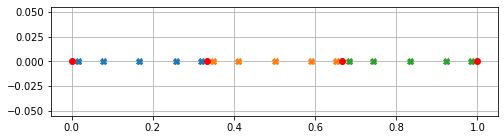

In [374]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.special import roots_legendre, eval_legendre

def geom(N, M, x0=0, x1=1):
    f = np.linspace(x0, x1, N+1)
    roots, weights = roots_legendre(M)
    c = [[f[i] + (f[i+1]-f[i])*(roots[j]+1)/2 for j in range(M)] for i in range(N)]
    return c, f, roots, weights

c, f, r, w = geom(3, 5)

plt.figure(figsize=(8, 2))
for _c in c:
    plt.plot(_c, np.zeros_like(_c), 'X')
plt.plot(f, np.zeros_like(f), 'ro')
plt.grid(True)
plt.show()

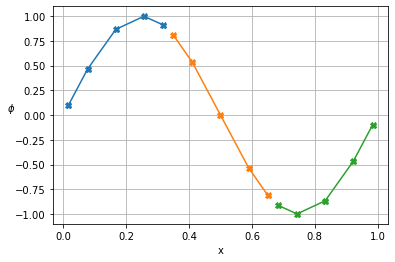

In [377]:
c, f, r, w = geom(3, 5)

def smooth(c):
    p0 = []
    for _c in c:
        p0.append([np.sin(2 * np.pi * __c) for __c in _c])
    return np.array(p0)

p0 = smooth(c)

for p, _c in zip(p0, c):
    plt.plot(_c, p, 'X-')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
plt.grid(True)
plt.show()

In [386]:
# parmámetros
N, M = 10, 3
c, f, r, w = geom(N, M)
u, dt, t, tf = 1, 0.001, 0, 1

# condiciones iniciales
p0 = smooth(c)
R0 = np.zeros_like(p0)

# matrices 

K = np.ones((M, M))

L = lambda i, x: np.prod([(x-r[j])/(r[i]-r[j]) for j in range(M) if j != i]) 
dL = lambda i, x: L(i, x)*np.sum([1/(r[i]-r[j]) for j in range(M) if j != i])
# p = [np.sum([p0(0.5*(r[i] + 1))*L(i, _x) for i in range(N)]) for _x in x*2-1]

while t < tf:
	
	# update temporal
	if t + dt > tf:
		dt = tf - t
	t = t + dt
	# print(f't = {t:.2f}, dt = {dt:.2f}')

	R = np.zeros_like(a0)
	f = np.zeros_like(a0)
	p = np.zeros_like(p0)
	for i in range(len(c)):
		# upwind
		if u > 0:
			if i == 0:
				q1 = np.sum([p0[len(c)-1, j]*L(j, 1) for j in range(M)])
			else:
				q1 = np.sum([p0[i-1, j]*L(j, 1) for j in range(M)])
			q2 = np.sum([p0[i, j]*L(j, 1) for j in range(M)])
		else:
			q1 = np.sum([p0[i, j]*L(j, 0) for j in range(M)])
			if i == len(c)-1:
				q2 = np.sum([p0[0, j]*L(j, 0) for j in range(M)])
			else:
				q2 = np.sum([p0[i + 1, j]*L(j, 0) for j in range(M)])
		# central
		# qlr = a0[i-1, 1] if i > 0 else a0[len(c)-1, 1]
		# qrl = a0[i+1, 0] if i < len(c)-1 else a0[0, 0]
		# ql, qr = a0[i, 0], a0[i, 1]
		# q1 = 0.5*(qlr+ql)
		# q2 = 0.5*(qr+qrl)
		f[i] = u * np.array([-q1, q2])
		R[i] = u * (K @ p0[i] - f[i])*2. / (w*(c[i][1] - c[i][0])**2)
		# euler
		p[i] = p0[i] + dt*R[i]
		# abs
		# a[i] = a0[i] + 1.5*dt*R[i] - 0.5*dt*R0[i]
	p0 = p.copy()
	R0 = R.copy()

	break

p = p0.copy()
for p, _c in zip(p0, c):
    plt.plot(_c, p, 'X-')
    plt.plot(_c, np.sin(2.*np.pi*(_c-u*t)), 'r-')
plt.xlabel('x')
plt.ylabel('$\phi$', rotation=0)
# plt.title(f'L2 = {np.linalg.norm(a-np.sin(2*np.pi*(np.array(c)-u*t))):.4f}')
plt.grid(True)
plt.show()

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [385]:
K @ p0[0]

array([0.90884186, 0.90884186, 0.90884186])

In [387]:
f[0]

array([-0.00200034,  0.58968578])